In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
import yfinance as yf
from keras.models import load_model

In [2]:
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
print(data.head())

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2010-01-04 00:00:00+00:00  6.447411  7.643214  7.660714  7.585000  7.622500   
2010-01-05 00:00:00+00:00  6.458558  7.656429  7.699643  7.616071  7.664286   
2010-01-06 00:00:00+00:00  6.355828  7.534643  7.686786  7.526786  7.656429   
2010-01-07 00:00:00+00:00  6.344078  7.520714  7.571429  7.466071  7.562500   
2010-01-08 00:00:00+00:00  6.386255  7.570714  7.571429  7.466429  7.510714   

Price                         Volume  
Ticker                          AAPL  
Date                                  
2010-01-04 00:00:00+00:00  493729600  
2010-01-05 00:00:00+00:00  601904800  
2010-01-06 00:00:00+00:00  552160000  
2010-01-07 00:00:00+00:00  477131200  
2010-01-08 00:00:00+00:00  447610800  


In [4]:
# Using only the 'Close' column
print(data[['Close']].values)

[[  7.64321423]
 [  7.65642881]
 [  7.53464317]
 ...
 [193.1499939 ]
 [193.58000183]
 [192.52999878]]


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [7]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [8]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [9]:
# Reshaping for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
# Building the model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

c:\Users\Deepraj\Desktop\PredictHub\server\LSTM-DL-MODEL\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Defining early stopping
from keras.callbacks import EarlyStopping

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 4.9681e-04 - val_loss: 0.0026
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 4.2257e-04 - val_loss: 0.0011
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.6867e-04 - val_loss: 0.0052
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.3142e-04 - val_loss: 0.0076
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 2.9384e-04 - val_loss: 0.0014
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.8322e-04 - val_loss: 7.2704e-04
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.6774e-04 - val_loss: 6.2600e-04
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.0651e-04 - val_loss: 7.3522e-04
Epoch 10/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.1652e-04 - val_loss: 0.0015
Epoch 11/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.5133e-04 - val_loss: 5.7892

In [15]:
# Saving the model to .h5
model.save('stock_price_prediction_model.h5')

In [17]:
# Predicting and inverse transforming
predictions = model.predict(X_test)

# Create an array of zeros with the same number of columns as the original data
predictions_extended = np.zeros((predictions.shape[0], scaled_data.shape[1]))

# Replace the 'Close' column with the predictions
predictions_extended[:, 3] = predictions.flatten()  # Assuming 'Close' is the 4th column (index 3)

# Inverse transform the extended predictions
predictions = scaler.inverse_transform(predictions_extended)[:, 3]  # Extract the 'Close' column

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [19]:
# Calculating RMSE
y_test_extended = np.zeros((y_test.shape[0], scaled_data.shape[1]))
y_test_extended[:, 3] = y_test  # Assuming 'Close' is the 4th column (index 3)

y_test_inverse = scaler.inverse_transform(y_test_extended)[:, 3]  # Extract the 'Close' column

rmse = np.sqrt(np.mean((predictions - y_test_inverse)**2))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 4.478903140814578


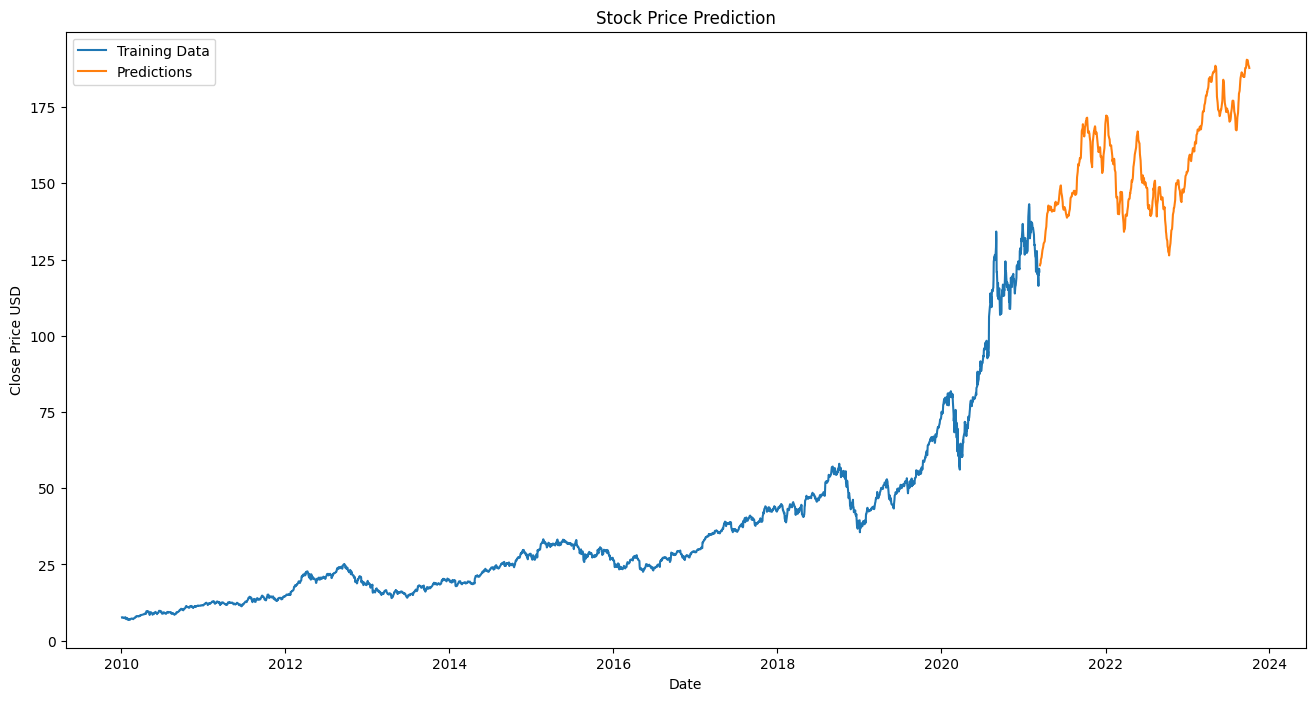

In [21]:
# Plotting the results
train = data[:train_size]
valid = data[train_size:train_size + len(predictions)].copy()
valid['Close'] = predictions.flatten()  # Update valid with predictions

plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Predictions')
plt.legend()
plt.show()